<a href="https://colab.research.google.com/github/Azizkhaled/NLP-with-Aziz/blob/main/Movie_Reviews_Classification_with_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.3 MB/s eta 0:00:00


Make sure to have download a kaggle.json from kaggle > Account > API > Create New Token

then upload the json file to kaggle

## Kaggle on Google Colab

In [3]:
!pip install kaggle

In [4]:
!mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

## Downloading the Rotten Tomatoes movie reviews dataset

If you get an error while downloading, you will need to agree to the competition rules from https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews/data

In [7]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi


In [8]:
import zipfile
import os

api = KaggleApi()
api.authenticate()



In [9]:
for file in ['train.tsv', 'test.tsv']:
    api.competition_download_file('sentiment-analysis-on-movie-reviews',
                                  f'{file}.zip', path='./')

    with zipfile.ZipFile(f'{file}.zip', 'r') as zip_ref:
        zip_ref.extractall('./')

    os.remove(f'{file}.zip')

100%|██████████| 1.28M/1.28M [00:01<00:00, 930kB/s]


100%|██████████| 494k/494k [00:01<00:00, 419kB/s]

## Preprocessing the data

.tsv (tab seperate values). we need to specify that  by sep = '\t'

In [73]:
import pandas as pd

df = pd.read_csv('train.tsv', sep = '\t')
df

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


### Removing duplicates

In [74]:
# df = df.drop_duplicates(subset=['SentenceId'], keep='first')
# commented out since the dataset it too small

In [75]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


The sentiment labels are:

0 - negative

1 - somewhat negative

2 - neutral

3 - somewhat positive

4 - positive

<Axes: >

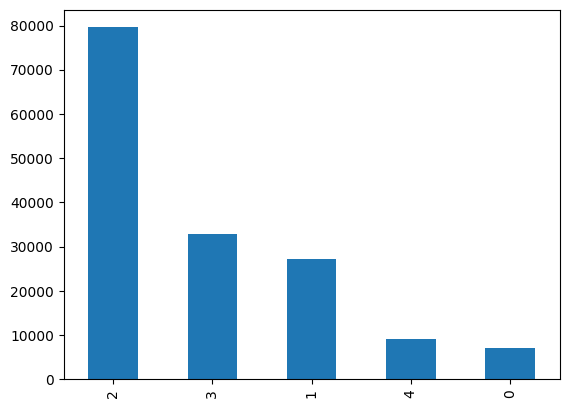

In [76]:
df['Sentiment'].value_counts().plot(kind='bar')

### Tokenizing

512 is the sequence length of our tokenized sequences for BERT

In [77]:
import numpy as np
num_samples = len(df)
seq_len = 512 #
num_samples, seq_len

(156060, 512)

#### Bert tokenizer

In [78]:
from transformers import BertTokenizer

# initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')


In [79]:
# tokenize - this time returning Numpy tensors
tokens = tokenizer(df['Phrase'].tolist(), max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True,
                   return_tensors='np')

returns us three numpy arrays - input_ids, token_type_ids, and attention_mask.

In [80]:
tokens.keys()


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [81]:
tokens['input_ids'][:10]


array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101, 13936, 25265, ...,     0,     0,     0],
       [  101, 13936, 25265, ...,     0,     0,     0],
       [  101, 15107,  1103, ...,     0,     0,     0]])

##### Save the tokens

In [82]:
# with open('movie-xids.npy', 'wb') as f:
#     np.save(f, tokens['input_ids'])
# with open('movie-xmask.npy', 'wb') as f:
#     np.save(f, tokens['attention_mask'])

### One hot encoding the labels

First we create a zero array with dimention (num_samples, num of labels)

In [83]:
# arr = df['Sentiment'].values
# we then initialize the zero array
labels = np.zeros((num_samples, df['Sentiment'].values.max()+1))
labels.shape

(156060, 5)

then we use fancy indexing to one hot encode

In [84]:
labels[np.arange(num_samples), df['Sentiment'].values] = 1

labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [85]:
print(df['Sentiment'].values[:3])
print(labels[:3])

[1 2 2]
[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


#### save the labels

In [86]:
# with open('movie-labels.npy', 'wb') as f:
#     np.save(f, labels)

## Creating an input pipeline

In [87]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((tokens['input_ids'], tokens['attention_mask'], labels))

dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

When feeding data into our model we need a two-item tuple in the format (< inputs >, < outputs >). Now, we have two tensors for our inputs - so, what we do is enter our < inputs > tensor as a dictionary {'input_ids': input_ids, 'attention_mask': masks}

and output as labels

In [88]:
def map_func(input_ids, masks, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [89]:
# then we use the dataset map method to apply this transformation
dataset = dataset.map(map_func)

dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int64, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

### Shuffling the data and batch it

and drop any samples that don't fit evenly into chunks of 16

In [90]:
batch_size = 16

dataset = dataset.shuffle(10000).batch(batch_size)

dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Split the dataset

In [91]:
split = 0.9

# we need to calculate how many batches must be taken to create 90% training set
size = int((tokens['input_ids'].shape[0] / batch_size) * split)

size

8778

In [92]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

# free up memory
del dataset

In [93]:
tf.data.Dataset.save(train_ds, 'train')
tf.data.Dataset.save(val_ds, 'val')

## Build and train the model

We will be building out what is essentially a frame around Bert, that will allow us to perform language classification

In [94]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-cased')

# we can view the model using the summary method
bert.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "tf_bert_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


Now we need to define the frame around Bert, we need:

- Two input layers (one for input IDs and one for attention mask).

- A post-bert dropout layer to reduce the likelihood of overfitting and improve generalization.

- Max pooling layer to convert the 3D tensors output by Bert to 2D.

- Final output activations using softmax for outputting categorical probabilities.

In [95]:
# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access final activations (alread max-pooled) [1]
# convert bert embeddings into 5 output classes
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

We can now define our model, specifying input and output layers. Finally, we can freeze the Bert layer because Bert is already highly trained, and contains a huge number of parameters so will take a very long time to train further. Nonetheless, if you'd like to train Bert too, there is nothing wrong with doing so.

In [96]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# (optional) freeze bert layer
# model.layers[2].trainable = False

# print out model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                         

In [97]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [98]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
8778/8778 [==============================] - 2083s 235ms/step - loss: 0.7840 - accuracy: 0.6729 - val_loss: 0.7258 - val_accuracy: 0.6949
Epoch 2/3
8778/8778 [==============================] - 2070s 236ms/step - loss: 0.6694 - accuracy: 0.7205 - val_loss: 0.7029 - val_accuracy: 0.7083
Epoch 3/3
8778/8778 [==============================] - 2072s 236ms/step - loss: 0.6049 - accuracy: 0.7473 - val_loss: 0.6719 - val_accuracy: 0.7258


### save the mpde;

In [101]:
model.save('sentiment_model_updated')
from google.colab import drive
drive.mount('/content/drive')
!zip -r /content/sentiment_model_updated.zip /content/sentiment_model_updated
from google.colab import files
files.download("/content/sentiment_model_updated.zip")


Mounted at /content/drive
  adding: content/sentiment_model_updated/ (stored 0%)
  adding: content/sentiment_model_updated/variables/ (stored 0%)
  adding: content/sentiment_model_updated/variables/variables.index (deflated 80%)
  adding: content/sentiment_model_updated/variables/variables.data-00000-of-00001 (deflated 16%)
  adding: content/sentiment_model_updated/fingerprint.pb (stored 0%)
  adding: content/sentiment_model_updated/saved_model.pb (deflated 92%)
  adding: content/sentiment_model_updated/assets/ (stored 0%)
  adding: content/sentiment_model_updated/keras_metadata.pb (deflated 96%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Make predictions

In [5]:
# !unzip sentiment_model.zip
import tensorflow as tf

model = tf.keras.models.load_model('content/sentiment_model')

Archive:  sentiment_model.zip
   creating: content/sentiment_model/
   creating: content/sentiment_model/variables/
  inflating: content/sentiment_model/variables/variables.index  
  inflating: content/sentiment_model/variables/variables.data-00000-of-00001  
 extracting: content/sentiment_model/fingerprint.pb  
  inflating: content/sentiment_model/saved_model.pb  
   creating: content/sentiment_model/assets/
  inflating: content/sentiment_model/keras_metadata.pb  


In [102]:


# view model architecture to confirm we have save and loaded correctly
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                         

Before making our predictions we need to format our data, which requires two steps:

- Tokenizing the data using the bert-base-cased tokenizer.

- Transforming the data into a dictionary containing 'input_ids' and 'attention_mask' tensors.

In [103]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}


0 - negative

1 - somewhat negative

2 - neutral

3 - somewhat positive

4 - positive

In [111]:
probs = model.predict(prep_data("If I ever read this line, I have to contact Aziz (azizkhaled) and tell him good job. He is definetly the best"))[0]

import numpy as np

np.argmax(probs)

1/1 [==============================] - 0s 46ms/step


4

In [105]:
import pandas as pd

# so we can see full phrase
pd.set_option('display.max_colwidth', None)

df = pd.read_csv('test.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine effort .
1,156062,8545,An intermittently pleasing but mostly routine effort
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [106]:
df = df.drop_duplicates(subset=['SentenceId'], keep='first')
df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine effort .
15,156076,8546,"Kidman is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet another example of the sad decline of British comedies in the post-Full Monty world ."
93,156154,8547,Once you get into its rhythm ... the movie becomes a heady experience .
117,156178,8548,I kept wishing I was watching a documentary about the wartime Navajos and what they accomplished instead of all this specious Hollywood hoo-ha .
158,156219,8549,"Kinnear does n't aim for our sympathy , but rather delivers a performance of striking skill and depth ."


In [107]:
df['Sentiment'] = None

for i, row in df.iterrows():
    # get token tensors
    tokens = prep_data(row['Phrase'])
    # get probabilities
    probs = model.predict(tokens)
    # find argmax for winning class
    pred = np.argmax(probs)
    # add to dataframe
    df.at[i, 'Sentiment'] = pred

df.head()

1/1 [==============================] - 0s 44ms/step


,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,An intermittently pleasing but mostly routine effort .,2
15,156076,8546,"Kidman is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet another example of the sad decline of British comedies in the post-Full Monty world .",1
93,156154,8547,Once you get into its rhythm ... the movie becomes a heady experience .,3
117,156178,8548,I kept wishing I was watching a documentary about the wartime Navajos and what they accomplished instead of all this specious Hollywood hoo-ha .,1
158,156219,8549,"Kinnear does n't aim for our sympathy , but rather delivers a performance of striking skill and depth .",4
